## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
 
# setting path
sys.path.append('..')

### Dependencies Installieren
Falls du es noch nicht getan hast, musst du vorher die entsprechenden Abhängigkeiten installieren:

In [ ]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install torchmetrics

In [4]:
import torch.nn as nn
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt
import torch
from pathlib import Path

## Data loading

### Pfade zu Daten

In [5]:
cache_path = '../cache/cache_v2'

### Daten laden
Gecachte, vorverarbeitete Daten vom Laufwerk in Speicher laden.

In [6]:
# Diese Funktion einfach ignorieren, sie lädt einfach nur die Daten aus der Cache-Datei, die ich dir geschickt hat.
# Es ist nur hässlich aus meinem Repo kopiert.
def load_cached(path):
    def load_npz_file(path):
        data = []
        with np.load(path) as npz_file:
            for name in npz_file.files:
                data.append(npz_file[name])
        return data
    cache_file = Path(path)
    image_path = cache_file.joinpath('images')
    label_path = cache_file.joinpath('labels')
    if image_path.with_suffix('.npy').is_file():
        images = np.load(str(image_path.with_suffix('.npy')))
        labels = np.load(str(label_path.with_suffix('.npy')))
        return images, labels
    else:
        images = load_npz_file(str(image_path.with_suffix('.npz')))
        labels = load_npz_file(str(label_path.with_suffix('.npz')))
        return images, labels

In [7]:
images, labels = load_cached(cache_path)

## Daten Visualisieren
Visualisiert das erste Bild mit der entsprechenden Segmentierungsmaske. Code muss man nicht sofort verstehen. Das Wichtige kommt danach.

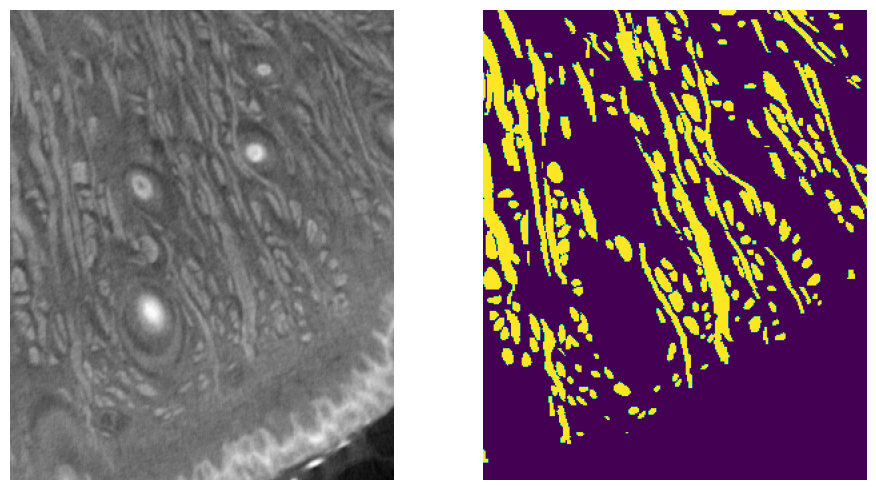

In [8]:
# Configure figure and axes
num_images = len(images)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


# Display grayscale image
axes[0].imshow(images[0], cmap='gray')
axes[0].axis('off')

axes[1].imshow(labels[0])
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Metriken Vergleichen

Erstes Bild nehmen und in PyTorch Tensor umwandeln, da die Metriken alle mit [PyTorch](https://pytorch.org/) arbeiten. PyTorch ist ein sehr gängigs ML-Framework für Python.

In [9]:
img_eval = torch.tensor(images[0])
lbl_eval = torch.tensor(labels[0], dtype=torch.long).unsqueeze(0)

Hilfsfunktion, um Bild zu verschieben:

In [10]:
def shift_image(image, right=0, down=0):
    c, h, w = image.shape
    shifted_image = torch.zeros_like(image)  # Create a tensor of zeros with the same shape as the input image
    shifted_image[:, down:h, right:w] = image[:, 0:h-down, 0:w-right]  # Shift pixels to the right by copying values from the original image
    return shifted_image

**Tatsächliche Metriken/Loss-Functions definieren.** Die Metriken berechnen ein Maß für den Unterschied zwischen der Vorhersage `prediction` und dem wahren Wert `target`. Binary Cross Entropy (BCE) ist die Kreuzentropie der beiden Werte (also effektiv ein Maß für wie die Verteilung sich unterscheidet). Der Dice-Koeffezient ist definiert als `2 * intersection(prediction, target) / (|prediction| + |target|)`, somit ein Maß für wie gut die vorhergesagte Segementierungsmaske, die echte reproduziert. Da eine loss function normalerweise minimiert wird, der Dice-Koeffizient jedoch am besten ist, wenn er den Wert 1 hat und bei 0 am schlechtesten ist, kann man den Dice loss definieren als `1 - dice_coefficient`.

In [11]:
bce_loss = nn.BCELoss()
dice_loss = torchmetrics.functional.dice

Wir definieren nun ein paar "predicted" Segmentierungen: Einmal um ein Pixel nach unten rechts verschoben, einmal nur Hintergrundpixel (0) und einmal die original Maske:

In [12]:
# Data type needs to be float because this is what the metrics expect for the input.
lbl_b_shifted = shift_image(lbl_eval, 1, 1).float()
lbl_b_black = torch.zeros_like(lbl_eval, dtype=torch.float)
lbl_b_same = lbl_eval.float()

**Hilfsfunktion, um für eine Metrik die Werte zu vergleichen.** Wir vergleichen nun jeder der gerade definierten Segmentierungen, mit dem Ground Truth. Da wir das für mehrere Metriken machen, hier eine kleine Funktion:

In [13]:
def compare_fn_outputs(fn, as_float=False):
    target = lbl_eval.float() if as_float else lbl_eval  # some metrics expect target of type to be float, some long.
    return fn(lbl_b_same, target), fn(lbl_b_shifted, target), fn(lbl_b_black, target)

In [14]:
("Same", "Shifted", "Black")

('Same', 'Shifted', 'Black')

In [15]:
compare_fn_outputs(bce_loss, True)

(tensor(0.), tensor(6.7310), tensor(20.3140))

In [16]:
compare_fn_outputs(torchmetrics.functional.dice)

(tensor(1.), tensor(0.8343), tensor(0.))

Wie erwartet, sind die Metriken am besten, wenn wir die identische Segmentierung vergleichen und am schlechtesten bei der auf 0 gesetzten Vorhersage. Das verschobene Bild ist dazwischen.